In [1]:
CUDA_INDEX = 5
NAME = 'AIDS-groups'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/AIDS/outer_groups.pt', map_location='cpu')
queries, targets, lb, ub = outer_test_set

In [7]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

94.27
84.39
85.30
84.47
98.75


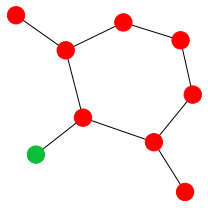

In [101]:
x = 4 # use 3, 4, 5 for samples for paper
plt.figure(figsize=(2.7,2.7))
plt.tight_layout()
viz.plot_graph(queries[x])
# plt.savefig(f'../plots/Query{x-2}.eps', bbox_inches='tight')
plt.show()
plt.close()

In [102]:
pred = torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')
topk_pred, topk_idx = torch.topk(pred, 5, dim=-1, largest=False)

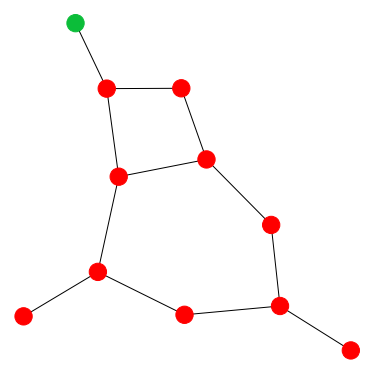

In [105]:
x = 4 # use 3, 4, 5 for samples for paper
# plt.figure(figsize=(2.7,2.7))
# plt.tight_layout()
# viz.plot_graph(queries[x])
# # plt.savefig(f'../plots/Query{x-2}.eps', bbox_inches='tight')
# plt.show()
# plt.close()
i = 1
plt.figure(figsize=(5,5))
plt.tight_layout()
viz.plot_graph(targets[topk_idx[x,i]])
#     print(ub[x,topk_idx[x,i]], pred[x,topk_idx[x,i]])
#     plt.show()
# plt.savefig(f'../plots/Query{x-2}.Rank{i+1}.eps', bbox_inches='tight')
# plt.savefig(f'../plots/Query{x-2}.Rank{i+1}.png', bbox_inches='tight')
plt.show()
#     plt.close()

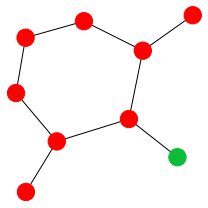

tensor(0.) tensor(1.4840)
tensor(0.) tensor(1.2054)
tensor(0.) tensor(2.0171)
tensor(0.) tensor(1.4324)
tensor(0.) tensor(1.0062)


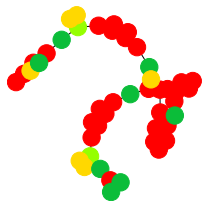

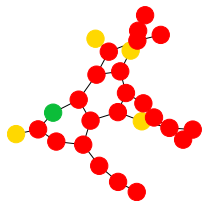

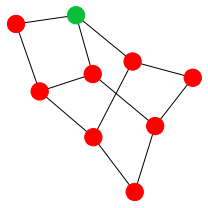

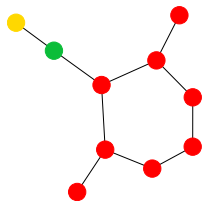

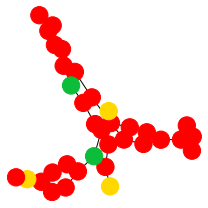

In [97]:
x = 4 # use 3, 4, 5 for samples for paper
plt.figure(figsize=(2.7,2.7))
plt.tight_layout()
viz.plot_graph(queries[x])
# plt.savefig(f'../plots/Query{x-2}.eps', bbox_inches='tight')
plt.show()
# plt.close()
for i in range(5):
    plt.figure(figsize=(2.7,2.7))
    plt.tight_layout()
    viz.plot_graph(targets[topk_idx[x,i]])
    print(ub[x,topk_idx[x,i]], pred[x,topk_idx[x,i]])
#     plt.show()
    plt.savefig(f'../plots/Query{x-2}.Rank{i+1}.eps', bbox_inches='tight')
#     plt.close()

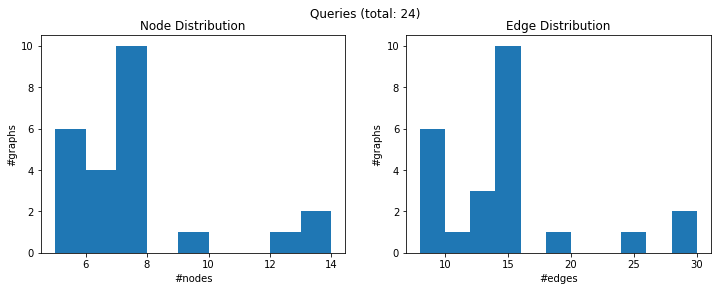

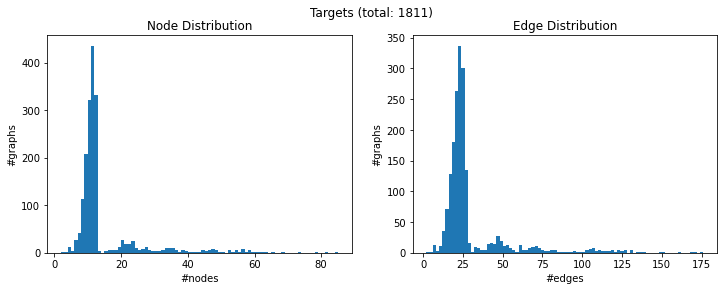

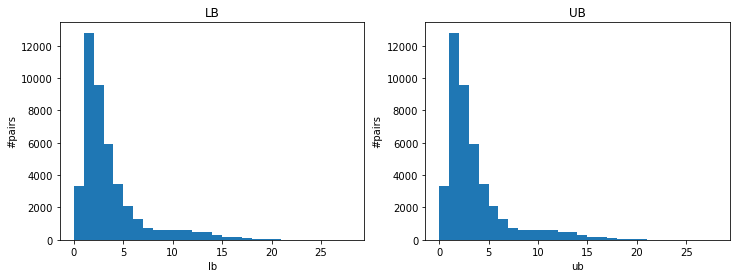

In [158]:
viz.plot_dataset_dist(outer_test_set)

In [7]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

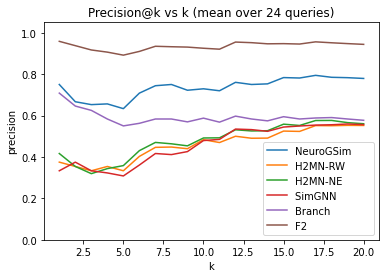

75.00 / 63.33 / 72.92 / 78.33 / 77.92
37.50 / 33.33 / 48.33 / 52.50 / 55.21
41.67 / 35.83 / 49.17 / 55.83 / 56.04
33.33 / 30.83 / 47.92 / 54.44 / 55.63
70.83 / 55.00 / 58.75 / 59.44 / 57.71
95.83 / 89.17 / 92.50 / 94.72 / 94.38


In [8]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [9]:
from scipy.stats import kendalltau
sed = (lb+ub)/2
for i, (label, pred) in enumerate(preds):
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(sed[i], pred[i], nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

0.796
0.719
0.729
0.725
0.642
0.850


In [163]:
for label, pred in preds:
#     print(f'{label}', end='\n')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([20]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

95.37
96.84
97.68
54.53
90.32
85.89
74.53


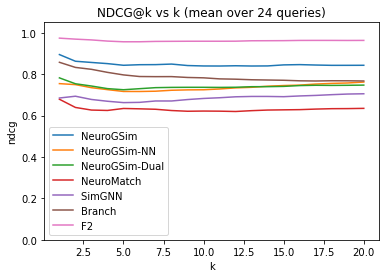

89.44 / 84.28 / 83.94 / 84.46 / 84.27
75.42 / 71.63 / 72.45 / 74.49 / 76.17
78.19 / 72.46 / 73.64 / 74.08 / 74.70
67.87 / 63.42 / 62.17 / 62.76 / 63.47
68.47 / 66.25 / 68.26 / 69.11 / 70.52
85.71 / 79.63 / 78.22 / 77.04 / 76.69
97.38 / 95.62 / 95.89 / 96.17 / 96.29


In [164]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

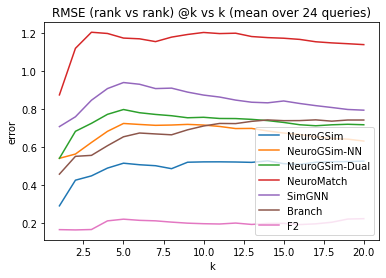

0.292 / 0.516 / 0.523 / 0.513 / 0.527
0.542 / 0.725 / 0.716 / 0.674 / 0.632
0.542 / 0.798 / 0.757 / 0.730 / 0.718
0.875 / 1.174 / 1.203 / 1.173 / 1.139
0.708 / 0.940 / 0.874 / 0.843 / 0.795
0.458 / 0.655 / 0.711 / 0.740 / 0.743
0.167 / 0.222 / 0.198 / 0.200 / 0.224


In [165]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

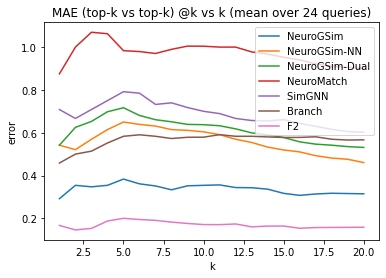

0.292 / 0.383 / 0.354 / 0.317 / 0.315
0.542 / 0.650 / 0.604 / 0.519 / 0.460
0.542 / 0.717 / 0.637 / 0.578 / 0.531
0.875 / 0.983 / 1.004 / 0.953 / 0.900
0.708 / 0.792 / 0.700 / 0.661 / 0.602
0.458 / 0.583 / 0.579 / 0.578 / 0.567
0.167 / 0.200 / 0.171 / 0.164 / 0.158


In [166]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)